# Connecting to a LangGraph Platform Deployment

## Deployment Creation

We showed how to create a [self-hosted deployment](https://langchain-ai.github.io/langgraph/how-tos/deploy-self-hosted/#how-to-do-a-self-hosted-deployment-of-langgraph) of LangGraph Platform [using the LangGraph CLI](https://langchain-ai.github.io/langgraph/concepts/langgraph_cli/#commands).

For the following examples, we'll launch a locally running LangGraph deployment with:

```
$ cd module-6/deployment
$ langgraph up
```

You will then see: 

```
Ready!       
- API: http://localhost:8123
- Docs: http://localhost:8123/docs
- LangGraph Studio: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:8123
```

## Using the API  

LangGraph Platform exposes [many API endpoints](https://github.com/langchain-ai/agent-protocol) for interacting with your agent! 

Our [agent protocol](https://github.com/langchain-ai/agent-protocol) organizes these endpoints into a few categories: 

* **Runs**: Atomic agent executions
* **Threads**: Multi-turn interactions
* **Store**: Long-term memory

We can test requests directly [in the API docs](http://localhost:8123/docs#tag/thread-runs)!

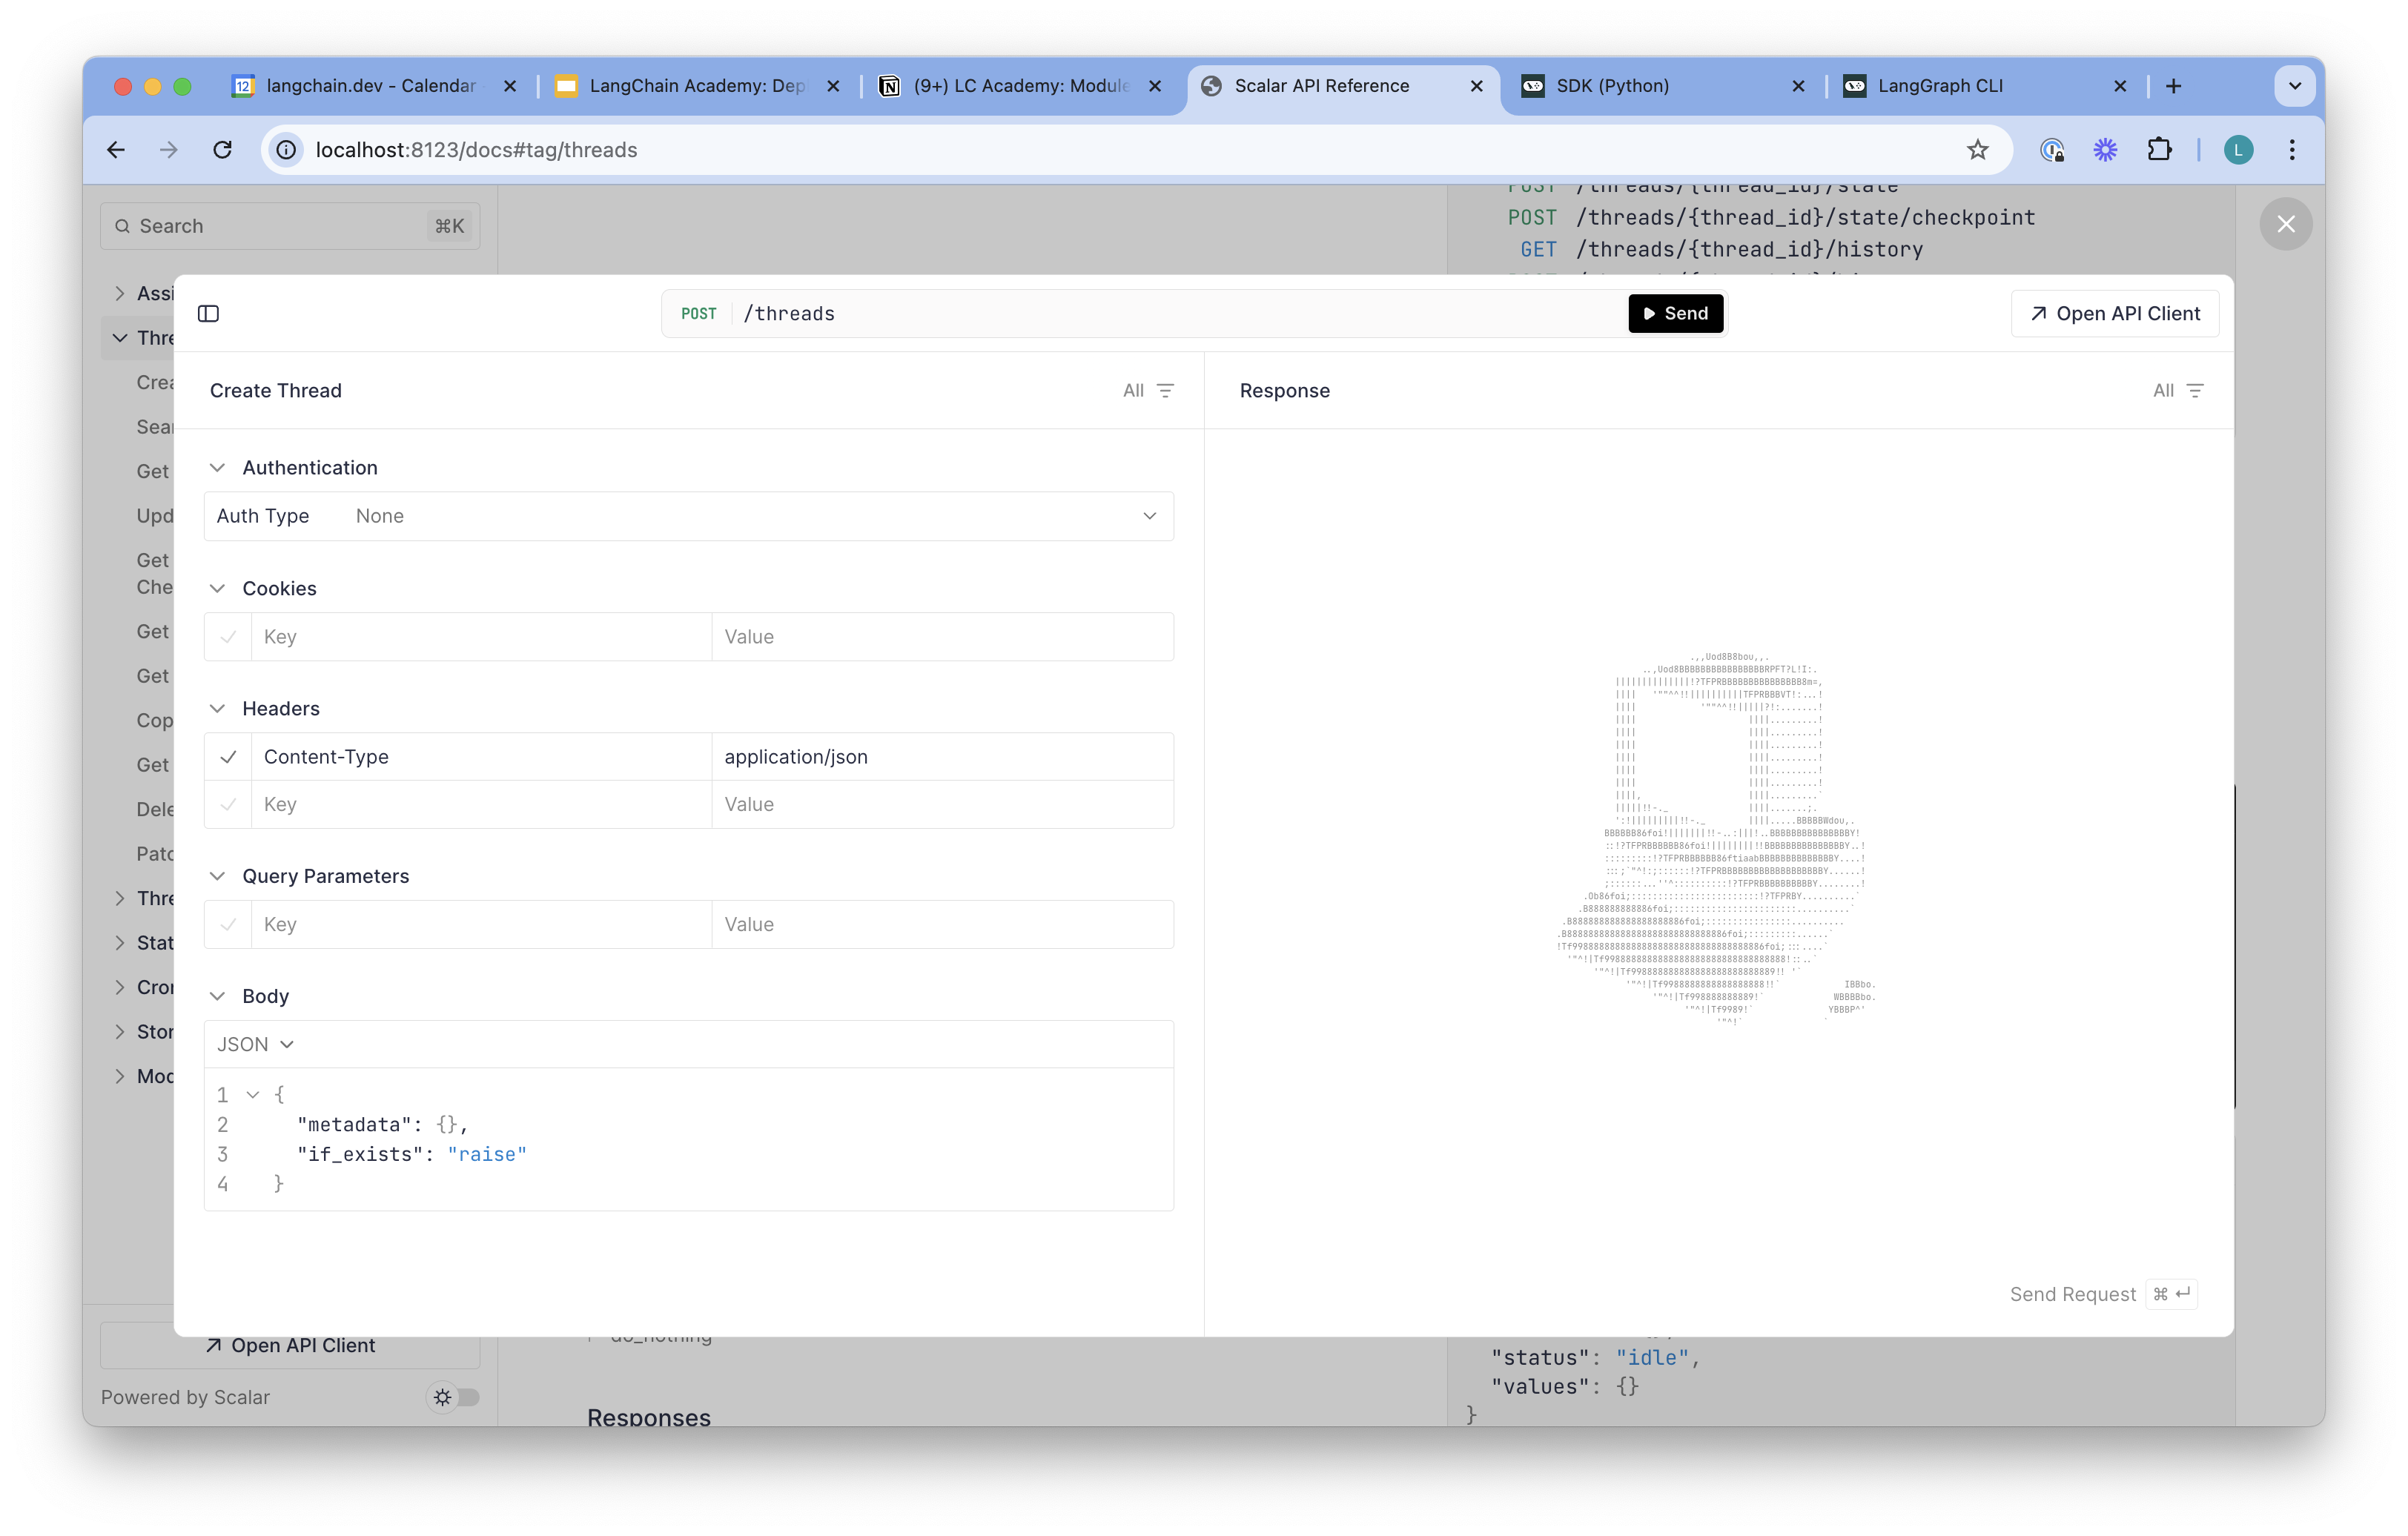

Of course, we can also [use `curl`](http://localhost:8123/docs#tag/assistants/POST/assistants/search) to directly call any of the API endpoints.

In [3]:
! curl --request POST \
  --url http://localhost:8123/assistants/search \
  --header 'Content-Type: application/json' \
  --data '{"metadata":{},"graph_id":"task_maistro","limit":10,"offset":0}'

[{"assistant_id":"ea4ebafa-a81d-5063-a5fa-67c755d98a21","graph_id":"task_maistro","created_at":"2024-11-08T21:51:08.277354+00:00","updated_at":"2024-11-08T21:51:08.277354+00:00","config":{},"metadata":{"created_by": "system"},"version":1,"name":"task_maistro"}]

## SDK

The [SDKs](https://langchain-ai.github.io/langgraph/concepts/sdk/) (Python/JavaScript) provide a developer-friendly interface to interact with the LangGraph Platform API presented above.

In [4]:
from langgraph_sdk import get_client
url_for_cli_deployment = "http://localhost:8123"
client = get_client(url=url_for_cli_deployment)
await client.assistants.search()

[{'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21',
  'graph_id': 'task_maistro',
  'created_at': '2024-11-08T21:51:08.277354+00:00',
  'updated_at': '2024-11-08T21:51:08.277354+00:00',
  'config': {},
  'metadata': {'created_by': 'system'},
  'version': 1,
  'name': 'task_maistro'}]

## Remote Graph

If you are working in the LangGraph library, [Remote Graph](https://langchain-ai.github.io/langgraph/how-tos/use-remote-graph/) is also a useful way to connect directly to the graph.

In [8]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph langchain_core langgraph_sdk

In [2]:
from langgraph.pregel.remote import RemoteGraph
from langchain_core.messages import convert_to_messages
from langchain_core.messages import HumanMessage, SystemMessage

# Get remote graph
url = "http://localhost:8123"
graph_name = "task_maistro" 
remote_graph = RemoteGraph(graph_name, url=url)

## Streaming

Our deployment enables streaming because updates from graph execution are published to Redis and returned to the client by the HTTP worker. 

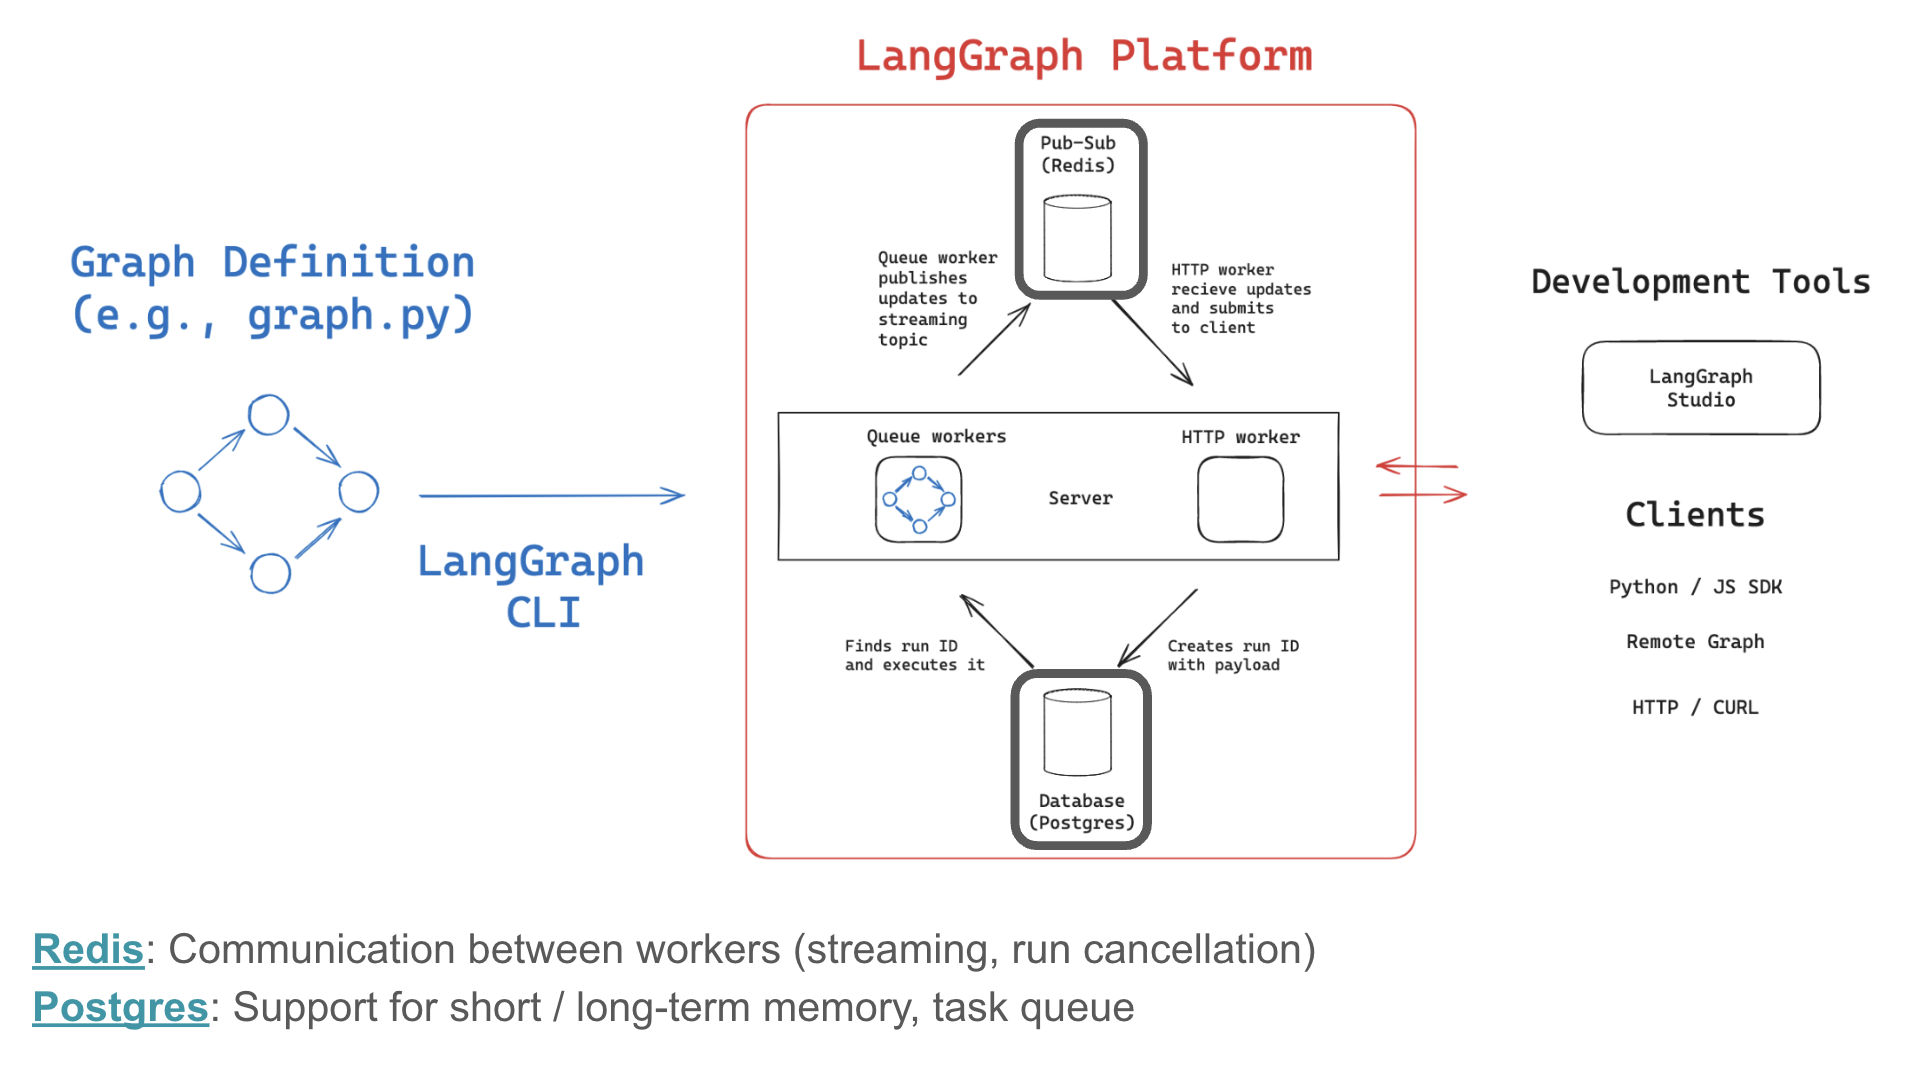

### Values

We can stream [the full state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) of the graph after each node is called.

The graph returns raw JSON because data is being transmitted across a network connection between the client and server.
 
We can use `convert_to_messages` if we want to convert JSON back to a LangChain `message` object.

In [4]:
# TODO: Update to use the SDK 
user_input = "Hi I'm Lance. I live in San Francisco with my wife and have a 1 year old."
config = {"configurable": {"user_id": "Lance"}}
for chunk in remote_graph.stream({"messages": [HumanMessage(content=user_input)]}, stream_mode="values", config=config):
    convert_to_messages(chunk["messages"])[-1].pretty_print()

================================ Human Message =================================

Hi I'm Lance. I live in San Francisco with my wife and have a 1 year old.
================================== Ai Message ==================================

Hi Lance! It's great to meet you. If there's anything specific you'd like help with, like managing your ToDo list or anything else, just let me know!


### Updates

Streams [the update to the state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) of the graph each each node is called.

You can see the difference between `values` and `updates` [here](https://langchain-ai.github.io/langgraph/concepts/streaming/#streaming-graph-outputs-stream-and-astream).

In [7]:
# TODO: Update to use the SDK 
user_input = "I also have a dog."
config = {"configurable": {"user_id": "Lance"}}
for chunk in remote_graph.stream({"messages": [HumanMessage(content=user_input)]}, stream_mode="updates", config=config):
    convert_to_messages(chunk['task_mAIstro']['messages'])[-1].pretty_print()

================================== Ai Message ==================================

Thanks for letting me know! If there's anything else you'd like to share or if you have any tasks related to your dog, feel free to let me know.


### Tokens

We can also stream tokens. 

In [5]:
# TODO: Update to use the SDK 
user_input = "My wifes parents live in Seoul."
config = {"configurable": {"user_id": "Lance"}}
for msg, metadata in remote_graph.stream({"messages": [HumanMessage(content=user_input)]}, stream_mode="messages", config=config):
    # TODO: Discuss w/ Vadym (tool call added to content in some cases)
    print(msg.get('content', ''), end="", flush=True)

Thanks for sharing that information! If there's anything else you'd like to add or discuss, feel free to let me know.

## Memory

Our local deployment also includes Postgres, providing both short (within thread) and long (acros thread) memory! 

Postgres provides `store` functionality, providing across thread persistence. 

In the below examples, we are persisting a profile, instructions, and ToDOs namespaced to `user_id: Lance`, just as we covered in Module 5.

It also support checkpointing to within-thread persistence, with thread-id being a `uuid`.

In [ ]:
import uuid
thread_id = str(uuid.uuid4())

In [18]:
# TODO: Update to use the SDK 
user_input = "Add a ToDo to sign up baby for swim lessons by end of November."
config = {"configurable": {"user_id": "Lance", "thread_id": thread_id}}
for chunk in remote_graph.stream({"messages": [HumanMessage(content=user_input)]}, stream_mode="values", config=config):
    convert_to_messages(chunk["messages"])[-1].pretty_print()

================================ Human Message =================================

Add a ToDo to sign up baby for swim lessons by end of November.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_wkvO6JCzTCdRepmXdvOiorWG)
 Call ID: call_wkvO6JCzTCdRepmXdvOiorWG
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Sign up baby for swim lessons', 'time_to_complete': 30, 'deadline': '2024-11-30T23:59:59', 'solutions': ['Check local community center for swim classes', 'Look for private swim instructors online', 'Ask friends for recommendations on swim schools'], 'status': 'not started'}
================================== Ai Message ==================================

I've added the task to sign up your baby for swim lessons by the end of November to your ToDo list. If you need any help with it, just let me know!


In [21]:
user_input = "On all ToDos, include local businesses that I should consider to complete the task."
for chunk in remote_graph.stream({"messages": [HumanMessage(content=user_input)]}, stream_mode="values", config=config):
    convert_to_messages(chunk["messages"])[-1].pretty_print()

================================ Human Message =================================

On all ToDos, include local businesses that I should consider to complete the task.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_giOkIpItgDvLZ5R58tO1Dmiu)
 Call ID: call_giOkIpItgDvLZ5R58tO1Dmiu
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Got it! I'll make sure to include a list of local businesses or resources for all your ToDos. If there's anything else you'd like to adjust, just let me know!


In [42]:
# verify that the state was persisted to the thread
thread_state = remote_graph.get_state(config)
for m in convert_to_messages(thread_state.values['messages']):
    m.pretty_print()

================================ Human Message =================================

Add a ToDo to sign up baby for swim lessons by end of November.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_wkvO6JCzTCdRepmXdvOiorWG)
 Call ID: call_wkvO6JCzTCdRepmXdvOiorWG
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Sign up baby for swim lessons', 'time_to_complete': 30, 'deadline': '2024-11-30T23:59:59', 'solutions': ['Check local community center for swim classes', 'Look for private swim instructors online', 'Ask friends for recommendations on swim schools'], 'status': 'not started'}
================================== Ai Message ==================================

I've added the task to sign up your baby for swim lessons by the end of November to your ToDo list. If you need any help with it, just let me know!
====================